In [93]:
import os
from os import listdir
from os.path import isfile, join
from IPython.display import Image, display
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import json
import random

import cv2

In [91]:
def rotate_image(mat, angle, corners=None):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]        

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    
    if corners is None:
        return rotated_mat
    else:
        bbox_points = np.array(corners).reshape((-1,1,2))
        rotated_points = cv2.transform(bbox_points, rotation_mat)
        return rotated_mat, rotated_points

In [76]:
def resize_percent(img, scale_percent):
    if not 0 <= scale_percent:
        raise Exception(f"scale_percent ({scale_percent}) should be more than 0")
        
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

def resize_shape(img, x, y):
    dim = (x, y)
    # resize image
    return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

def resize_x(img, x):
    y = int(x * img.shape[1] / img.shape[0])
    dim = (y, x)
    # resize image
    return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

In [85]:
def insert_center(dst, src):
    src_h,src_w,src_c = src.shape
    dst_h,dst_w,dst_c = dst.shape
    
    if dst_h < src_h:
        raise Exception(f"dst_h({dst_h}) < src_h({src_h})")
    if dst_w < src_w:
        raise Exception(f"dst_w({dst_w}) < src_w({src_w})")
    x_offset=(dst_w - src_w) // 2
    y_offset=(dst_h - src_h) // 2
    dst[y_offset:y_offset+src.shape[0], x_offset:x_offset+src.shape[1]] = src
    return [
        [x_offset, y_offset+src.shape[0]], 
        [x_offset+src.shape[1], y_offset+src.shape[0]], 
        [x_offset+src.shape[1], y_offset], 
        [x_offset, y_offset]
    ]

### Generation parameters

In [133]:
# parameters
back_dir = "backs"
card_dir = "cards"
output_img_dir = "images"
output_mark_dir = "corners"


output_shape = [512, 512]

resize_x_list = list(range(128, 390, 32))
rotate_angle_list = list(range(-60, 61, 10))

In [134]:
back_imgs = [f for f in listdir(back_dir) if isfile(join(back_dir, f))]
card_imgs = [f for f in listdir(card_dir) if isfile(join(card_dir, f))]

In [135]:
count = len(rotate_angle_list) * len(resize_x_list) * len(back_imgs) * len(card_imgs)
print(f"Generated images count: {count}")

Generated images count: 14040


In [112]:
corner_dict = dict()
for b, back_path in enumerate(back_imgs):
    print(f"\r{b+1}/{len(back_imgs)}", end="")
    for c, card_path in enumerate(card_imgs):
        card_img = cv2.imread(card_dir + "\\" + card_path)
        
        for r, resize_x_coef in enumerate(resize_x_list):
            res_card_img = resize_x(card_img, resize_x_coef)
            
            back_img = resize_shape(cv2.imread(back_dir + "\\" + back_path), output_shape[0], output_shape[1])
            corners = insert_center(back_img, res_card_img)
            
            for a, rotate_angle in enumerate(rotate_angle_list):
                result_image, rot_corners = rotate_image(back_img, rotate_angle, corners)
                
                
                
                cv2.imwrite(output_img_dir + "\\" + f"img_{b}_{c}_{r}_{a}.png", result_image)
                corner_dict[f"img_{b}_{c}_{r}_{a}.png"] = rot_corners.squeeze().tolist()
        
with open(output_mark_dir + '\\corners.json', 'w') as fp:
    json.dump(corner_dict, fp)

1/15

### Verification

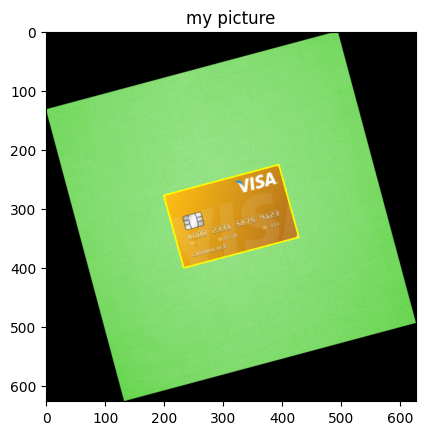

In [138]:
data_imgs = [f for f in listdir(output_img_dir) if isfile(join(output_img_dir, f))]
img_path = random.choice(data_imgs)
img = cv2.imread(output_img_dir + "\\" + img_path)

bbox = corner_dict[img_path]

cv2.line(img, bbox[0], bbox[1], (255, 255, 0), thickness=2)
cv2.line(img, bbox[1], bbox[2], (255, 255, 0), thickness=2)
cv2.line(img, bbox[2], bbox[3], (255, 255, 0), thickness=2)
cv2.line(img, bbox[3], bbox[0], (255, 255, 0), thickness=2)

plt.imshow(img)
plt.title('my picture')
plt.show()